**Part A**

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")

 **Load Datasets**

In [70]:
fear_greed=pd.read_csv('/content/fear_greed_index (1).csv')
trades=pd.read_csv('/content/historical_data (1).csv')

In [71]:
fear_greed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [72]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

Rows, Cloumns

In [73]:
print("Fear Greed shape:", fear_greed.shape)

Fear Greed shape: (2644, 4)


In [74]:

print("Trades shape:", trades.shape)

Trades shape: (211224, 16)


**Missing Values(Null values)**

In [75]:
fear_greed.isna().sum()

,0
timestamp,0
value,0
classification,0
date,0


In [76]:
trades.isna().sum()

,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


**Duplicates**

In [77]:
fear_greed.duplicated().sum()

np.int64(0)

In [78]:
trades.duplicated().sum()

np.int64(0)

In [79]:
fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.date

In [80]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M")
trades['date'] = trades['Timestamp IST'].dt.date

In [81]:
df = trades.merge(
    fear_greed[['date', 'classification']],
    on='date',
    how='left'
)

In [82]:
df[['date', 'classification']].head()


,date,classification
0,2024-12-02,Extreme Greed
1,2024-12-02,Extreme Greed
2,2024-12-02,Extreme Greed
3,2024-12-02,Extreme Greed
4,2024-12-02,Extreme Greed


In [83]:
print("Rows after merge:", df.shape[0])
print("Missing sentiment rows:", df['classification'].isna().sum())


Rows after merge: 211224
Missing sentiment rows: 6


In [84]:
df = df.dropna(subset=['classification'])


**Daily PnL**

In [85]:
daily_pnl = (
    df.groupby(['Account', 'date'])['Closed PnL']
    .sum()
    .reset_index()
)

**win rate**

In [86]:
df['win'] = df['Closed PnL'] > 0

win_rate = (
    df.groupby('Account')['win']
    .mean()
    .reset_index(name='win_rate')
)

**Average Trade size**

In [87]:
avg_trade_size = (
    df.groupby('Account')['Size USD']
    .mean()
    .reset_index(name='avg_trade_size')
)

In [88]:
df['leverage_proxy'] = df['Size USD'] / df['Execution Price']

avg_leverage = (
    df.groupby('Account')['leverage_proxy']
    .mean()
    .reset_index(name='avg_leverage')
)

In [89]:
trades_per_day = (
    df.groupby(['Account', 'date'])
    .size()
    .reset_index(name='trades_per_day')
)


In [90]:
df['is_long'] = df['Side'].str.lower() == 'buy'

long_short_ratio = (
    df.groupby('Account')['is_long']
    .mean()
    .reset_index(name='long_ratio')
)


In [91]:
trader_metrics = (
    win_rate
    .merge(avg_trade_size, on='Account')
    .merge(avg_leverage, on='Account')
    .merge(long_short_ratio, on='Account')
)


In [92]:
trader_metrics.head()

,Account,win_rate,avg_trade_size,avg_leverage,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612,16159.576734,16.167205,0.448140
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720,1653.226327,503.067952,0.419643
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917,8893.000898,190.601382,0.411132
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585,507.626933,2073.877844,0.503268
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914,3138.894782,27144.279511,0.364001


**Part B**

In [93]:
daily_sentiment_pnl = (
    df.groupby(['date', 'classification'])['Closed PnL']
    .sum()
    .reset_index()
)

**Plot**

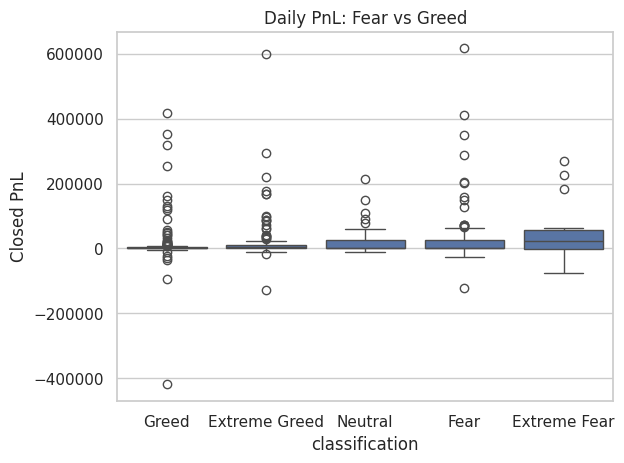

In [94]:
sns.boxplot(
    data=daily_sentiment_pnl,
    x='classification',
    y='Closed PnL'
)
plt.title("Daily PnL: Fear vs Greed")
plt.show()

**Trade Frequency**

In [95]:
trade_frequency = (
    df.groupby(['date', 'classification'])
    .size()
    .reset_index(name='trade_count')
)


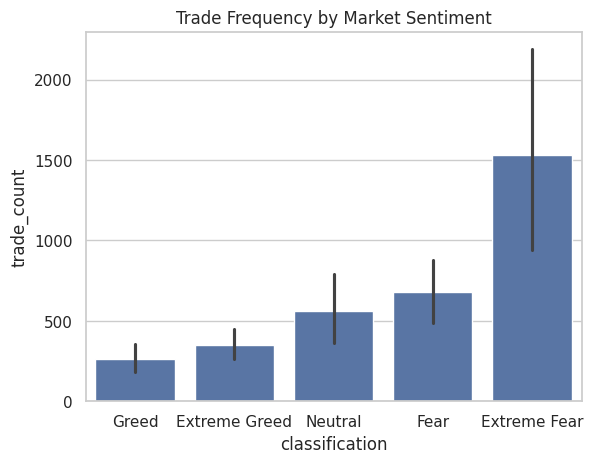

In [96]:
sns.barplot(
    data=trade_frequency,
    x='classification',
    y='trade_count'
)
plt.title("Trade Frequency by Market Sentiment")
plt.show()


**Position size by sentiment**

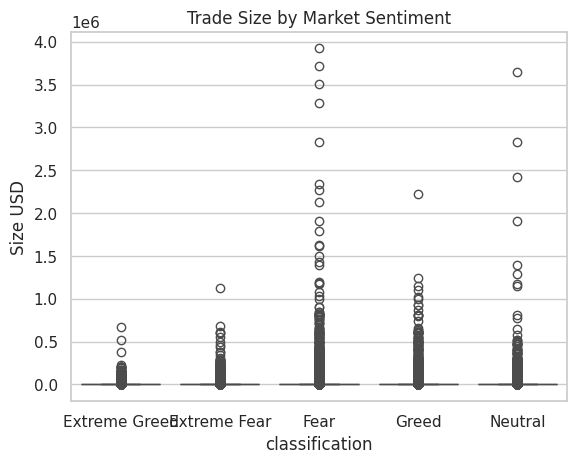

In [98]:
sns.boxplot(
    data=df,
    x='classification',
    y='Size USD'
)
plt.title("Trade Size by Market Sentiment")
plt.show()

High vs Low Leverage trades

In [99]:
df['leverage_group'] = np.where(
    df['leverage_proxy'] >= df['leverage_proxy'].median(),
    'High Leverage',
    'Low Leverage'
)


In [101]:
trade_counts = df.groupby('Account').size()

df['frequency_group'] = df['Account'].map(
    lambda x: 'Frequent'
    if trade_counts[x] >= trade_counts.median()
    else 'Infrequent'
)


Consistent vs Inconsistent traders

In [104]:
pnl_std = df.groupby('Account')['Closed PnL'].std()

df['consistency_group'] = df['Account'].map(
    lambda x: 'Consistent'
    if pnl_std[x] <= pnl_std.median()
    else 'Inconsistent'
)

**Clustering**

In [105]:
features = trader_metrics[
    ['win_rate', 'avg_trade_size', 'avg_leverage', 'long_ratio']
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
trader_metrics['cluster'] = kmeans.fit_predict(X_scaled)


In [107]:
trader_metrics.groupby('cluster').mean(numeric_only=True)

,win_rate,avg_trade_size,avg_leverage,long_ratio
cluster,,,,
0,0.373800,12170.710473,1833.604205,0.558617
1,0.810876,2600.778049,56700.083879,0.498231
2,0.397438,3232.979989,3280.122633,0.414924


In [109]:
daily = daily_pnl.merge(
    fear_greed,
    left_on='date',
    right_on='date',
    how='left'
)

daily['profitable'] = daily['Closed PnL'] > 0

In [111]:
X = pd.get_dummies(daily[['classification']], drop_first=True)
y = daily['profitable']


In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [113]:
model = LogisticRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)


0.6082621082621082